In [1]:
import os
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataset import Dataset
from pipeline import Pipeline
from visualizations import Visualizer
from sklearn.linear_model import Ridge
import sklearn.preprocessing
from sklearn.svm import LinearSVR
from sklearn.decomposition import PCA, KernelPCA
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_squared_percentage_error
from scipy.linalg import LinAlgWarning
import warnings
# Filter out LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning)
#controling whether tensorflow does recognize GPU
tf.config.get_visible_devices("GPU")
np.random.seed(42)

In [2]:
#Inititate processing pipeline
pipeline = Pipeline(crypto_tick = "btc")
#Initiate visualizer
visualizer = Visualizer()

In [3]:
print("Missing values distribution:")
visualizer.get_missing_columns(data = pipeline.data)

Missing values distribution:


{'BTC / Capitalization, market, estimated supply, USD': [3092, '% 70.594'],
 'BTC / Volatility, daily returns, 180d': [11, '% 0.251'],
 'Wiki_btc_search': [1640, '% 37.443'],
 'Close_^DJI': [1360, '% 31.05'],
 'Close_^GSPC': [1360, '% 31.05'],
 'Close_GC=F': [1363, '% 31.119'],
 'Close_^VIX': [1360, '% 31.05'],
 'Close_^IXIC': [1360, '% 31.05'],
 'Close_SMH': [1360, '% 31.05'],
 'Close_VGT': [1360, '% 31.05'],
 'Close_XSD': [1360, '% 31.05'],
 'Close_IYW': [1360, '% 31.05'],
 'Close_FTEC': [2067, '% 47.192'],
 'Close_IGV': [1360, '% 31.05'],
 'Close_QQQ': [1360, '% 31.05'],
 'Wiki_crypto_search': [1640, '% 37.443'],
 'USD_EUR_rate': [161, '% 3.676'],
 'BTC-USD': [1353, '% 30.89']}

/tmp/ipykernel_35058/523243249.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


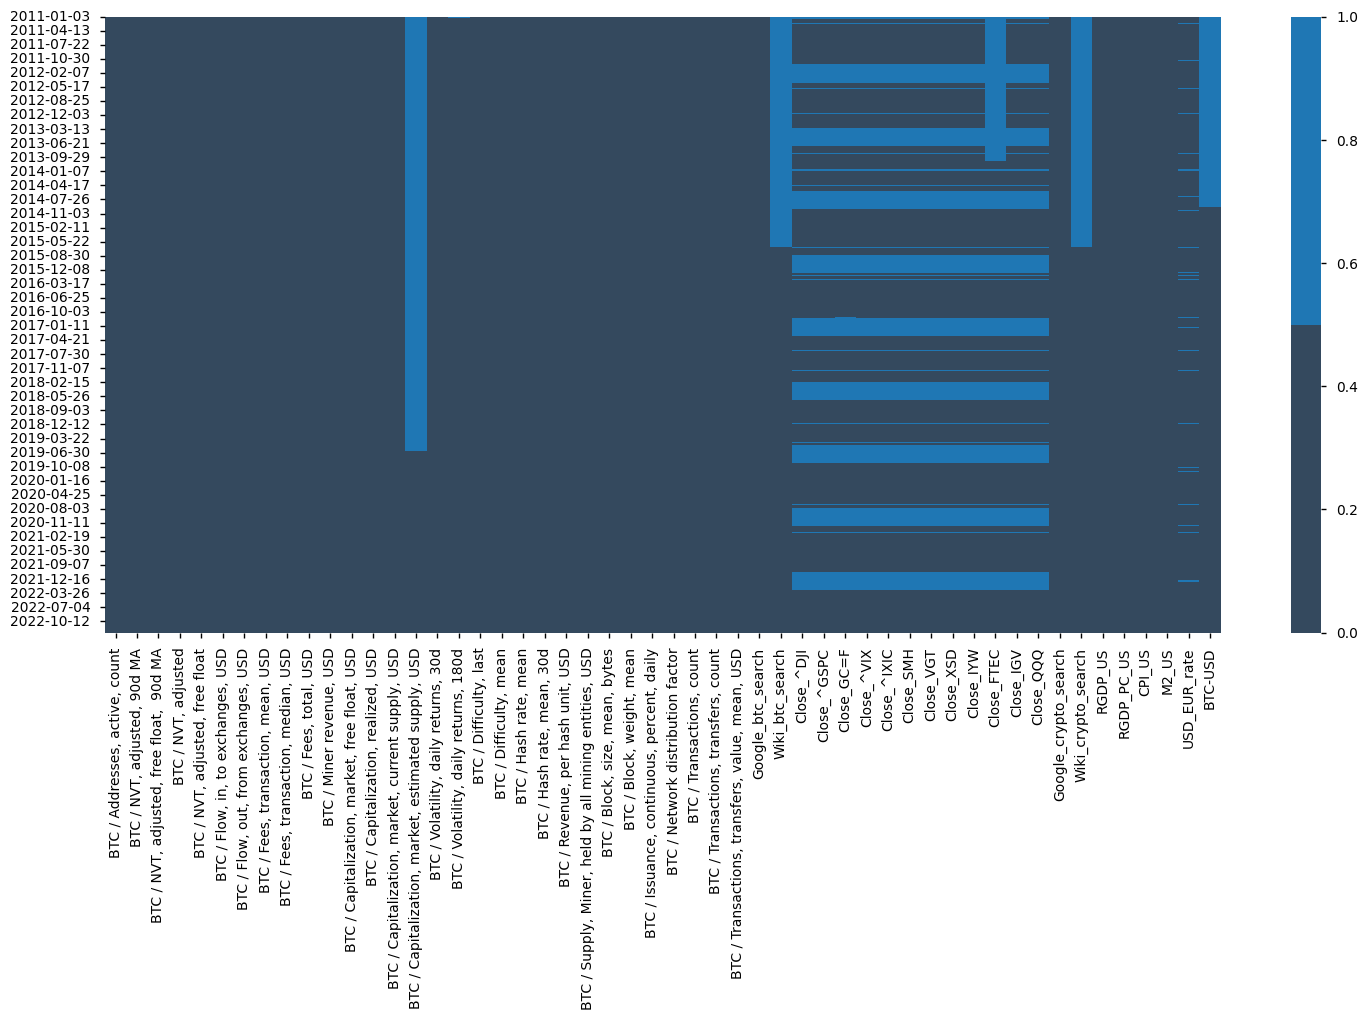

In [4]:
fig = visualizer.draw_missing_data(data = pipeline.data)
fig.show()

In [5]:
pipeline.set_beginning(start_date = "2014-9-17")

/tmp/ipykernel_35058/523243249.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


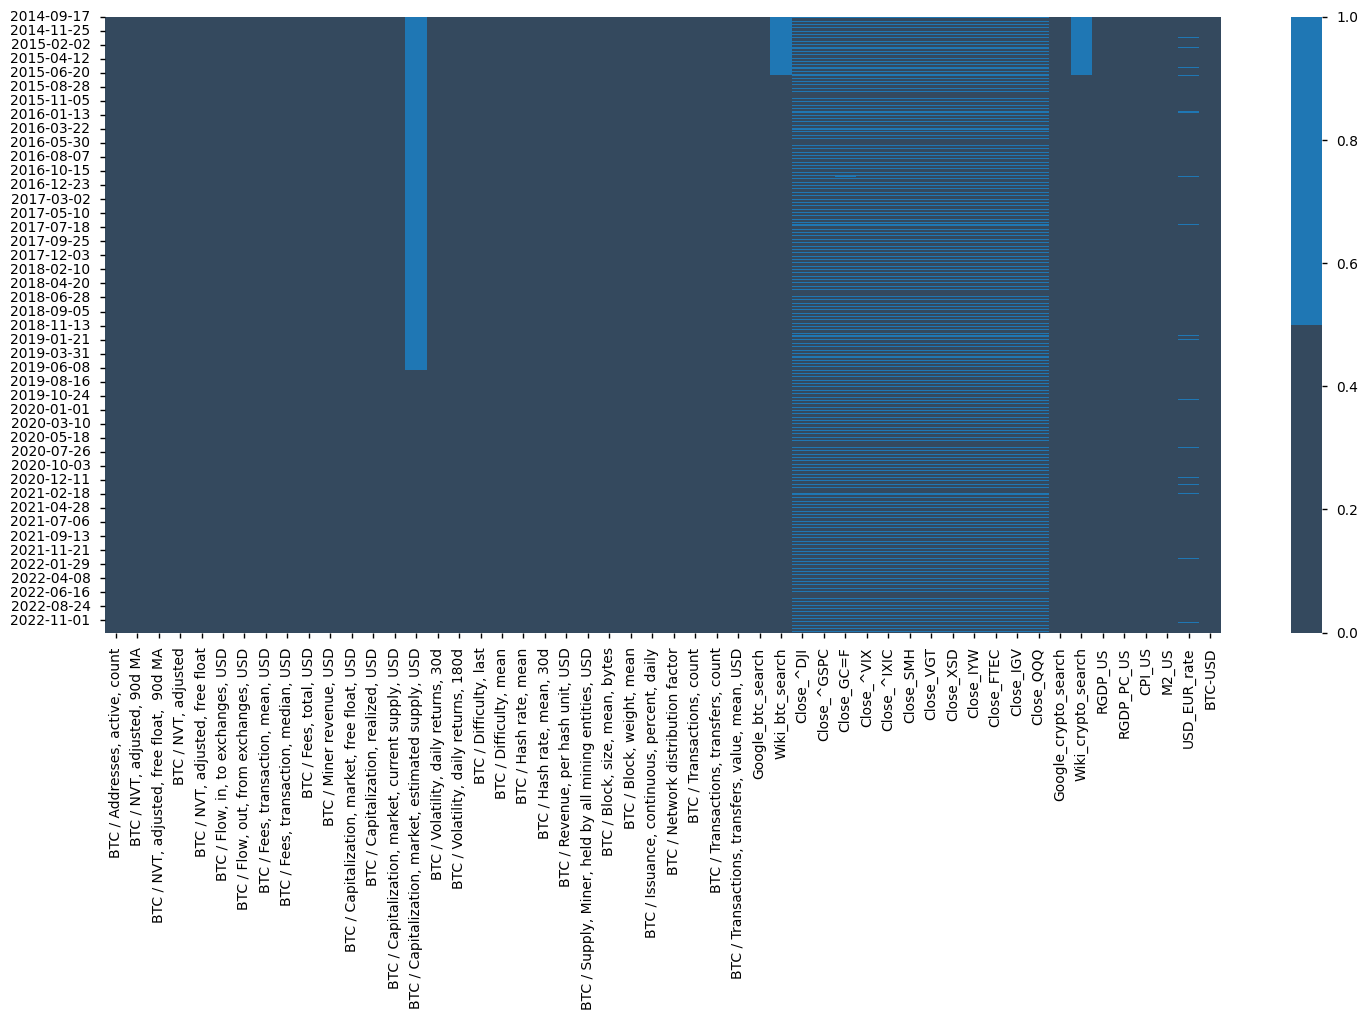

In [6]:
fig = visualizer.draw_missing_data(data = pipeline.data)
fig.show()

In [7]:
pipeline.preprocess_dataset()

/tmp/ipykernel_35058/523243249.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


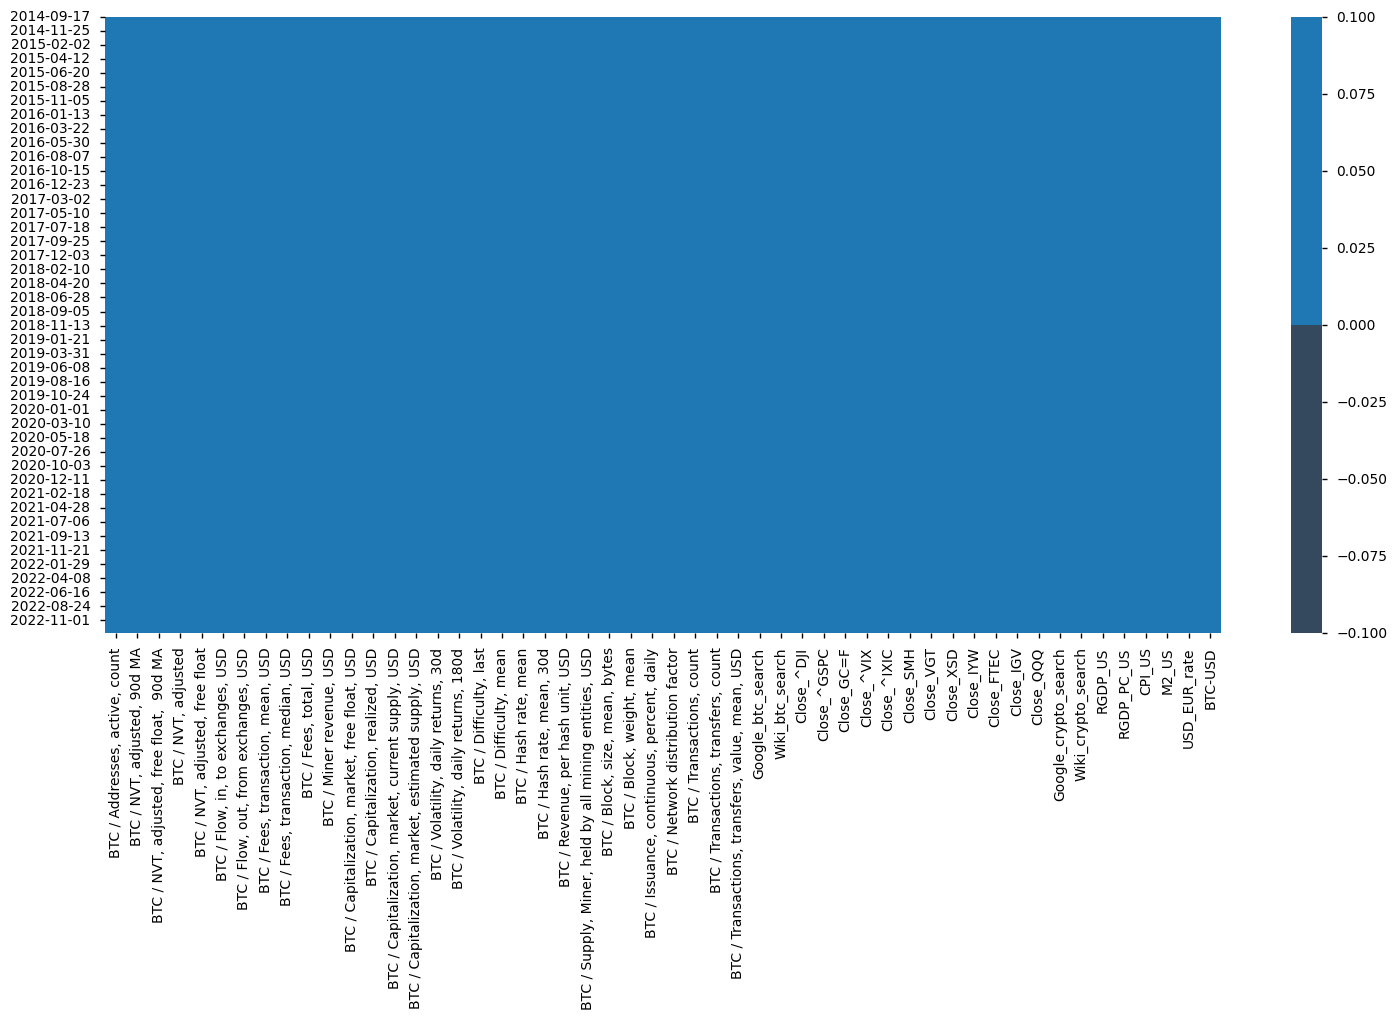

In [8]:
fig = visualizer.draw_missing_data(data = pipeline.data)
fig.show()

In [9]:
pipeline.shift_target()

In [10]:
columns = ["BTC-LR - 1 day", "BTC-LR - 5 days", 
           "BTC-LR - 10 days", "BTC-SVR - 1 day", "BTC-SVR - 5 days", "BTC-SVR - 10 days", "BTC-LTSM - 1 day", "BTC-LTSM - 5 days","BTC-LTSM - 10 days"]
rows = ["Full dimensionality", "95% retained variance",
        "98% retained variance", "99% retained variance"]
#presented in RMSE which is the optimized metric
results_train_averaged = pd.DataFrame(columns = columns, index = rows)

In [11]:
columns = ["BTC-LR - 1 day", "BTC-LR - 5 days", 
           "BTC-LR - 10 days", "BTC-SVR - 1 day", "BTC-SVR - 5 days", "BTC-SVR - 10 days", "BTC-LTSM - 1 day", "BTC-LTSM - 5 days","BTC-LTSM - 10 days"]
rows = ["Full dimensionality", "95% retained variance",
        "98% retained variance", "99% retained variance"]
#presented in RMSE which is the optimized metric
results_test = pd.DataFrame(columns = columns, index = rows)

# PCA retained variance on the whole dataset

0.38521102617588926


/tmp/ipykernel_35058/391077607.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


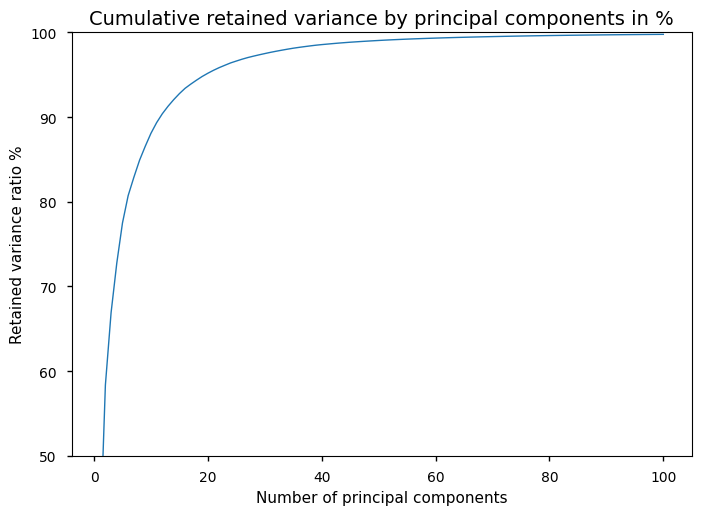

In [12]:
pca = KernelPCA(kernel = "rbf", fit_inverse_transform = True, random_state = 42, gamma=1e-3, alpha=5e-3)
scaler = sklearn.preprocessing.RobustScaler(unit_variance = True)
kpca = pca.fit_transform(scaler.fit_transform(pipeline.data_1d_shift.iloc[:,:-1]))
explained_variance = np.var(kpca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumulative_varience_ratio = np.cumsum(explained_variance_ratio)
fig = visualizer.draw_cumulative_varience_ratios(cumulative_varience_ratio[:100])
fig.show()

In [13]:
print("Explained variance by component")
explained_variance_ratio

Explained variance by component


array([3.85211026e-01, 1.98406333e-01, 8.54139664e-02, ...,
       3.97477108e-13, 3.92923390e-13, 3.89718433e-13])

# Full dimensionality - baseline models

The pipeline is always shown for 1 day forecasting. 5 and 10 day forecasting is performed without further comments 

## Full dimensionality - Linear Regression

In [14]:
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = None)
pipe

Pipeline(steps=[('scaler', RobustScaler(unit_variance=True)),
                ('denoiser', None), ('estimator', Ridge(random_state=42))])

In [15]:
LR_PARAMETERS = {"estimator__alpha": np.linspace(0,5,20),
              "estimator__tol":[0.0001, 0.0005,0.001],
              "estimator__max_iter":[200,500,1000,2000]}
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_1d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["Full dimensionality"],["BTC-LR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-LR - 1 day"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.13798e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.13798e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.13798e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.13798e-28): r

{'estimator__alpha': 0.2631578947368421, 'estimator__max_iter': 200, 'estimator__tol': 0.0001}
Pipeline(steps=[('scaler', RobustScaler(unit_variance=True)),
                ('denoiser', None),
                ('estimator',
                 Ridge(alpha=0.2631578947368421, max_iter=200,
                       random_state=42))])
-1320.86503213918


## Full dimensionality - 5 and 10 days - LR

In [18]:
#5 days LR
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = None)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["Full dimensionality"],["BTC-LR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-LR - 5 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)
#10 days LR
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = None)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["Full dimensionality"],["BTC-LR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-LR - 10 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.12648e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.12648e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.12648e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.12648e-28): r

## Full dimensionality - Support Vector Regression

In [16]:
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = None)
pipe

Pipeline(steps=[('scaler', RobustScaler(unit_variance=True)),
                ('denoiser', None), ('estimator', LinearSVR(random_state=42))])

In [ ]:
SVR_PARAMETERS = {"estimator__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "estimator__epsilon": [0.01, 0.1, 0.2, 0.5, 1.0],
              "estimator__tol":[0.0001, 0.0005,0.001],
              "estimator__max_iter":[200,500,1000,2000]}
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_1d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["Full dimensionality"],["BTC-SVR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-SVR - 1 day"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

## Full dimensionality - 5 and 10 days - SVR

In [ ]:
#5 days SVR
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = None)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["Full dimensionality"],["BTC-SVR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-SVR - 5 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

#10 days SVR
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = None)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["Full dimensionality"],["BTC-SVR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-SVR - 10 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)


## Full dimensionality - LTSM


In [17]:
""" pipe = Pipeline.assembly_pipeline(estimator = ..., dim_reducer = None)
pipe """

' pipe = Pipeline.assembly_pipeline(estimator = ..., dim_reducer = None)\npipe '

## Full dimensionality - 5 and 10 days - LSTM

In [ ]:
#5 days LSTM

#10 days LSTM


# Retained 95% of variance

## Retained 95% of variance - Linear Regression

In [19]:
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
pipe

Pipeline(steps=[('scaler', RobustScaler(unit_variance=True)),
                ('denoiser', PCATransformer(pca=PCA(n_components=0.95))),
                ('estimator', Ridge(random_state=42))])

In [20]:
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_1d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["95% retained variance"],["BTC-LR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-LR - 1 day"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.12828e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.12828e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (r

In [21]:
#5 days LR
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["95% retained variance"],["BTC-LR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-LR - 5 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)
#10 days LR
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["95% retained variance"],["BTC-LR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-LR - 10 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.13897e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.13897e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.13897e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.13897e-26): r

## Retained 95% of variance - Support Vector Regression

In [22]:
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
pipe

Pipeline(steps=[('scaler', RobustScaler(unit_variance=True)),
                ('denoiser', PCATransformer(pca=PCA(n_components=0.95))),
                ('estimator', LinearSVR(random_state=42))])

In [ ]:
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_1d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["95% retained variance"],["BTC-SVR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-SVR - 1 day"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

## Retained 95% of variance - 5 and 10 days - SVR

In [ ]:
#5 days SVR
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["95% retained variance"],["BTC-SVR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-SVR - 5 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)
#10 days SVR
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["95% retained variance"],["BTC-SVR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-SVR - 10 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

## Retained 95% of variance - LSTM

In [23]:
""" pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(Pipeline.assembly_lstm, 
                loss = "mse"), dim_reducer = pca)
pipe """

' pca = PCA(n_components = 0.95)\npipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(Pipeline.assembly_lstm, \n                loss = "mse"), dim_reducer = pca)\npipe '

# Retained 98% of variance

## Retained 98% of variance - Linear Regression

In [24]:
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
pipe

Pipeline(steps=[('scaler', RobustScaler(unit_variance=True)),
                ('denoiser', PCATransformer(pca=PCA(n_components=0.98))),
                ('estimator', Ridge(random_state=42))])

In [25]:
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_1d_shift)
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["98% retained variance"],["BTC-LR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["98% retained variance"],["BTC-LR - 1 day"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.12828e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.12828e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.12828e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.12828e-26): r

In [26]:
#5 days LR
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["98% retained variance"],["BTC-LR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["98% retained variance"],["BTC-LR - 5 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)
#10 days LR
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["98% retained variance"],["BTC-LR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["98% retained variance"],["BTC-LR - 10 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.13897e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.13897e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.13897e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.13897e-26): r

## Retained 98% of variance - Support Vector Regression

In [27]:
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
pipe

Pipeline(steps=[('scaler', RobustScaler(unit_variance=True)),
                ('denoiser', PCATransformer(pca=PCA(n_components=0.98))),
                ('estimator', LinearSVR(random_state=42))])

In [ ]:
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_1d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["98% retained variance"],["BTC-SVR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["98% retained variance"],["BTC-SVR - 1 day"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

## Retained 98% of variance - 5 and 10 days - SVR

In [ ]:
#5 days SVR
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["98% retained variance"],["BTC-SVR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["98% retained variance"],["BTC-SVR - 5 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)
#10 days SVR
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["95% retained variance"],["BTC-SVR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-SVR - 10 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

## Retained 98% of variance - LSTM

In [28]:
""" pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(), dim_reducer = pca)
pipe """

' pca = PCA(n_components = 0.98)\npipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(), dim_reducer = pca)\npipe '

# Retained 99% of variance

## Retained 99% of variance - Linear Regression

In [29]:
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
pipe

Pipeline(steps=[('scaler', RobustScaler(unit_variance=True)),
                ('denoiser', PCATransformer(pca=PCA(n_components=0.99))),
                ('estimator', Ridge(random_state=42))])

In [30]:
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_1d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["99% retained variance"],["BTC-LR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["99% retained variance"],["BTC-LR - 1 day"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.12828e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.12828e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.12828e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.12828e-26): r

In [31]:
#5 days LR
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["99% retained variance"],["BTC-LR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["99% retained variance"],["BTC-LR - 5 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)
#10 days LR
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["99% retained variance"],["BTC-LR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["99% retained variance"],["BTC-LR - 10 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.13897e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.13897e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.13897e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.13897e-26): r

## Retained 99% of variance - Support Vector Regression

In [32]:
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
pipe

Pipeline(steps=[('scaler', RobustScaler(unit_variance=True)),
                ('denoiser', PCATransformer(pca=PCA(n_components=0.99))),
                ('estimator', LinearSVR(random_state=42))])

In [ ]:
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_1d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["99% retained variance"],["BTC-SVR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["99% retained variance"],["BTC-SVR - 1 day"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

In [ ]:
#5 days SVR
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["99% retained variance"],["BTC-SVR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["99% retained variance"],["BTC-SVR - 5 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)
#10 days SVR
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["95% retained variance"],["BTC-SVR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-SVR - 10 days"]] = mean_squared_percentage_error(test_target,
                                                                prediction, square_root=True)

## Retained 99% of variance - LSTM

In [33]:
""" pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(), dim_reducer = pca)
pipe """

' pca = PCA(n_components = 0.99)\npipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(), dim_reducer = pca)\npipe '

In [34]:
results_test

,BTC-LR - 1 day,BTC-LR - 5 days,BTC-LR - 10 days,BTC-SVR - 1 day,BTC-SVR - 5 days,BTC-SVR - 10 days,BTC-LTSM - 1 day,BTC-LTSM - 5 days,BTC-LTSM - 10 days
Full dimensionality,0.036467,0.097397,0.172337,NaN,NaN,NaN,NaN,NaN,NaN
95% retained variance,0.360798,0.387142,0.391668,NaN,NaN,NaN,NaN,NaN,NaN
98% retained variance,0.040519,0.081681,0.118431,NaN,NaN,NaN,NaN,NaN,NaN
99% retained variance,0.044386,0.083641,0.126979,NaN,NaN,NaN,NaN,NaN,NaN
